<h1 align="center"><b>Homework Assignment 2 (100 points total)</b></h1>
<h3 align="center"><b>Assigned at the start of Module 3</b></h3>
<h3 align="center"><b>Due at the end of Module 5</b></h3><br>


# Q1: Outlier Detection with Mahalanobis Distance

## Developing multi-variate methods for outlier detection (40 points total)

The **Mahalanobis distance** provides a statistical measure of the distance between a point and a distribution. When applied to multivariate data, **ellipses** can help visualize outliers by showing confidence regions for different standard deviations.

You have been given a dataset (**Iris dataset**) with three species of flowers: **Setosa, Versicolor, and Virginica**. Each species has measurements for:
- **Sepal Length**
- **Sepal Width**
- **Petal Length**
- **Petal Width**

---

## **Tasks**

### **1. Conceptual Understanding (10 points)**
- Explain why **Mahalanobis distance-based ellipses** are useful for outlier detection.
- Compare this method with **standard deviation-based outlier detection** in one-dimensional data.

### <strong>Response</strong>
#### The ellipses represent regions where most of the data points are expected to fall, based on their Mahalanobis distance. These contours show areas of equal probability, meaning points far from the center are less likely to belong to the main distribution. In one-dimensional data, distances are treated equally in all directions.

### **2. Implementation (10 points)**
- Use the provided code to **generate ellipses** for all three species using the features **sepal_length** and **petal_width**.
- Modify the class **`sigma_ellipse_plot`** to allow for the selection of **custom standard deviation thresholds** (e.g., `[1.5, 2.5, 3.5]` instead of `[1, 2, 3]`).

## Example Code

In [461]:
import warnings
warnings.filterwarnings("ignore")

In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import math
from scipy.stats.distributions import chi2
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from sklearn import datasets
#%matplotlib inline

class sigma_ellipse_plot:

    def __init__(self, df=None, target='setosa', target_header='species', feature1='sepal_length', feature2='petal_width', std_devs=[1, 2, 3]):

        self.data = df
        self.target = target
        self.feature1 = feature1
        self.feature2 = feature2
        self.target_header = target_header
        self.std_devs=std_devs
        self.largest_eigenvalue = None
        self.largest_eigenvector = None
        self.smallest_eigenvalue = None
        self.smallest_eigenvector = None
        self.angle = None
        self.mean = None
        self.r_ellipses = None
        self.mu_X = None
        self.mu_Y = None
        self.chisquare_val = None

    def get_data(self):

        self.data = self.data[self.data[self.target_header] == self.target].drop(self.target_header, axis =1)[[self.feature1, self.feature2]]

        return

    def get_eigens(self):

        covariance_matrix = self.data.cov()
        eigenvalues, eigenvectors = eigh(covariance_matrix)

        self.largest_eigenvector = eigenvectors[np.argmax(eigenvalues)]
        self.largest_eigenvalue = np.max(eigenvalues)
        self.smallest_eigenvector = eigenvectors[np.argmin(eigenvalues)]
        self.smallest_eigenvalue = np.min(eigenvalues)

        return

    def get_angle(self):

        self.angle = math.atan2(self.largest_eigenvector[1], self.largest_eigenvector[0])

        return

    def shift_angle(self):

        if self.angle < 0:
            self.angle = self.angle + 2*math.pi

        return

    def get_mean(self):

        self.mean = self.data.mean()

        return

    def get_chisquare_vals(self):

        self.chisquare_val = []
        for i in range(0, len(self.std_devs)):
            percent_covered = stats.norm.cdf(self.std_devs[i]) - stats.norm.cdf(self.std_devs[i] * -1)
            self.chisquare_val.append((chi2.ppf(percent_covered, df=2))**0.5)

        return self.chisquare_val

    def get_ellipses(self):

        chisquare_val = self.get_chisquare_vals()

        self.r_ellipses = []
        for i in range(0, len(self.std_devs)):
            theta_grid = np.linspace(0,2*math.pi, 100)
            phi = self.angle
            self.mu_X = self.mean[0]
            self.mu_Y = self.mean[1]
            a = chisquare_val[i] * math.sqrt(self.largest_eigenvalue)
            b = chisquare_val[i] * math.sqrt(self.smallest_eigenvalue)

            ellipse_x_r = a * np.cos(theta_grid)
            ellipse_y_r = b * np.sin(theta_grid)

            R = [[math.cos(phi), math.sin(phi)], [-math.sin(phi), math.cos(phi)]]

            ellipses = np.array([ellipse_x_r, ellipse_y_r])

            r_ellipse = ellipses.T.dot(R).T

            self.r_ellipses.append(r_ellipse)

        return
    
    def get_labels(self, special_phrase=None):

        labels = []
        for i in range(0, len(self.std_devs)):

            if special_phrase is None:
                label = str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)
            else: 
                label = special_phrase + str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)

        return labels

    def pipeline(self):

        self.get_data()
        self.get_eigens()
        self.get_angle()
        self.shift_angle()
        self.get_mean()
        self.get_ellipses()

        return self.data, self.r_ellipses, self.mu_X, self.mu_Y

In [463]:
## Import Dataset ##

iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.columns = (
    df.columns.str.replace(' ', '_') 
    .str.replace(r'\(cm\)', '', regex=True) 
    .str.lower()
    .str.rstrip('_')) 
df['species'] = iris.target
df['species'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
print(df.head())

## Feature Definition ##

feature1 = 'sepal_width'
feature2 = 'petal_width'

## Species Specific Ellipse Generation ##

setosa_ellipses_obj = sigma_ellipse_plot(df=df, target='setosa', feature1=feature1, feature2=feature2, std_devs=[1.5, 2.5, 4])
setosa_df, setosa_ellipses, setosa_mu_X, setosa_mu_Y = setosa_ellipses_obj.pipeline()
setosa_plot_labels = setosa_ellipses_obj.get_labels()

versicolor_ellipses_obj = sigma_ellipse_plot(df=df, target='versicolor', feature1=feature1, feature2=feature2, std_devs=[1.5, 2.5, 4])
versicolor_df, versicolor_ellipses, versicolor_mu_X, versicolor_mu_Y = versicolor_ellipses_obj.pipeline()
versicolor_plot_labels = versicolor_ellipses_obj.get_labels()

virginica_ellipses_obj = sigma_ellipse_plot(df=df, target='virginica', feature1=feature1, feature2=feature2, std_devs=[1.5, 2.5, 4])
virginica_df, virginica_ellipses, virginica_mu_X, virginica_mu_Y = virginica_ellipses_obj.pipeline()
virginica_plot_labels = virginica_ellipses_obj.get_labels()

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


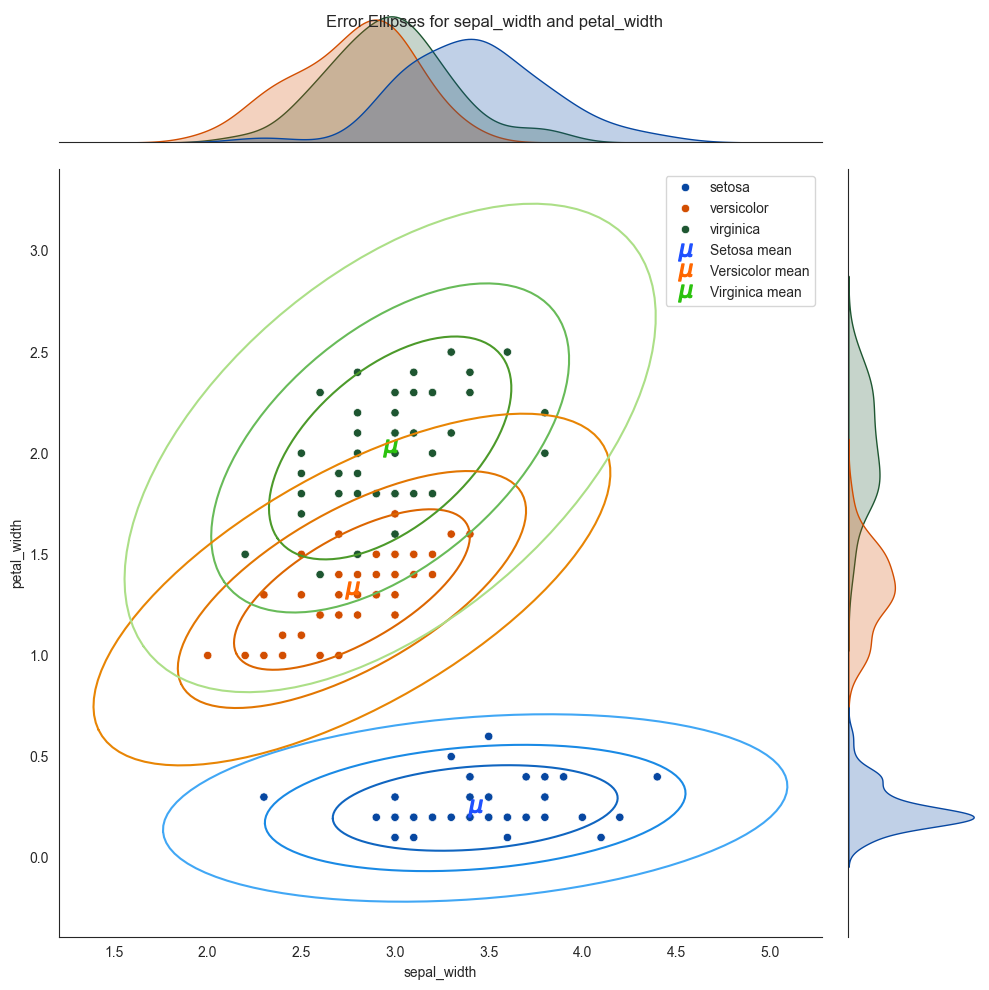

In [464]:
## Visualization of Ellipse Plots ##

sns.set_style("white")

df_subset = df[[feature1, feature2, 'species']]

# palette order - setosa, virginica, versicolor
petal_width_plot = sns.jointplot(data=df_subset, x=feature1, y=feature2, hue="species", palette = ["#0747a1", '#d24e01','#1e5631' ], height = 10)
colors_for_plot_setosa = ['#1065c0', '#1a8ae5', '#41a7f5']
colors_for_plot_virginica = ['#4c9a2a', '#68bb59', '#acdf87']
colors_for_plot_versicolor = ['#dc6601', '#e27602', '#e88504']

# Dynamic title for chart 
plt.suptitle(f"Error Ellipses for {feature1} and {feature2}" )

plt.scatter(setosa_mu_X, setosa_mu_Y, c='#1F51FF', s=150, label = 'Setosa mean', marker='$\mu$')
plt.scatter(versicolor_mu_X, versicolor_mu_Y, c='#FF6700', s=150, label = 'Versicolor mean', marker='$\mu$')
plt.scatter(virginica_mu_X, virginica_mu_Y, c='#2Bc20e', s=150, label = 'Virginica mean', marker='$\mu$')

plt.legend()

# Plots the ellipses for each species, with the appropriate colors 
for i in range(0, len(setosa_ellipses)):
    plt.plot(setosa_ellipses[i][0] + setosa_mu_X, setosa_ellipses[i][1] + setosa_mu_Y, colors_for_plot_setosa[i], label= setosa_plot_labels[i])
    plt.plot(versicolor_ellipses[i][0] + versicolor_mu_X, versicolor_ellipses[i][1] + versicolor_mu_Y, colors_for_plot_versicolor[i], label= versicolor_plot_labels[i])
    plt.plot(virginica_ellipses[i][0] + virginica_mu_X, virginica_ellipses[i][1] + virginica_mu_Y, colors_for_plot_virginica[i], label= virginica_plot_labels[i])


# Save the plot as an image
plt.savefig('MahalanobisOultlierExample.svg')

# Show the plot (optional)
plt.show()

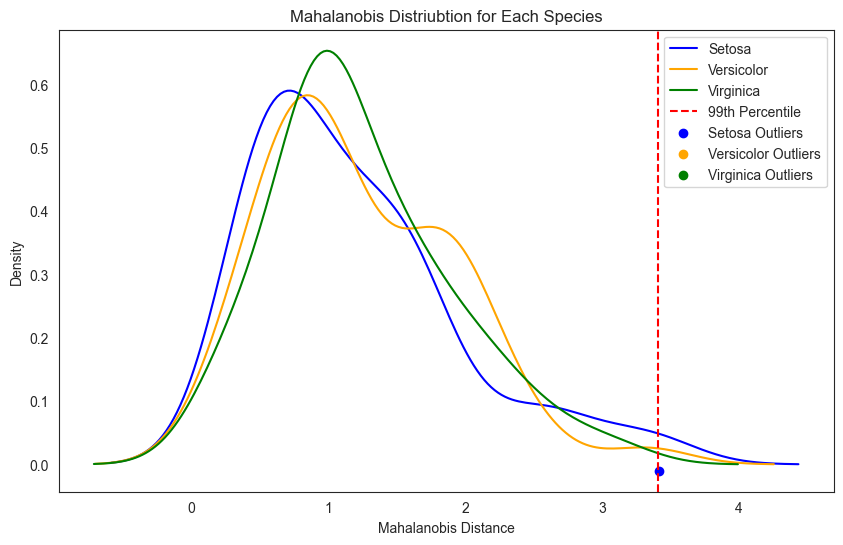

In [465]:
# generate plot with mahalanobis distance
def mahalanobis_distance(df, target, feature1, feature2):  
    data = df[df['species'] == target][[feature1, feature2]]
    covariance_matrix = data.cov()
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    mean = data.mean()
    
    mahalanobis_distribution = data.apply(lambda x: np.sqrt((x - mean).dot(inv_covariance_matrix).dot((x - mean).T)), axis=1)
    return mahalanobis_distribution

setosa_mahalanobis = mahalanobis_distance(df, 'setosa', feature1, feature2)
versicolor_mahalanobis = mahalanobis_distance(df, 'versicolor', feature1, feature2)
virginica_mahalanobis = mahalanobis_distance(df, 'virginica', feature1, feature2)

df['setosa_mahalanobis'] = setosa_mahalanobis
df['versicolor_mahalanobis'] = versicolor_mahalanobis
df['virginica_mahalanobis'] = virginica_mahalanobis

# chi-squared value for 3 degrees of freedom
chi2_val = chi2.ppf(0.997, df=2)
threshold = np.sqrt(chi2_val)

df['setosa_outlier'] = df['setosa_mahalanobis'] > threshold
df['versicolor_outlier'] = df['versicolor_mahalanobis'] > threshold
df['virginica_outlier'] = df['virginica_mahalanobis'] > threshold

df['setosa_outlier'] = df['setosa_outlier'].map({True: 'Outlier', False: 'Normal'})
df['versicolor_outlier'] = df['versicolor_outlier'].map({True: 'Outlier', False: 'Normal'})
df['virginica_outlier'] = df['virginica_outlier'].map({True: 'Outlier', False: 'Normal'})

# Plot the Mahalanobis distance for each species
plt.figure(figsize=(10, 6))
plt.title('Mahalanobis Distriubtion for Each Species')

sns.kdeplot(setosa_mahalanobis, color='blue', label='Setosa')
sns.kdeplot(versicolor_mahalanobis, color='orange', label='Versicolor')
sns.kdeplot(virginica_mahalanobis, color='green', label='Virginica')

plt.axvline(threshold, color='red', linestyle='--', label='99th Percentile')

outliers = df[df['setosa_outlier'] == 'Outlier']
plt.scatter(outliers['setosa_mahalanobis'], [-0.01] * outliers.shape[0], color='blue', label='Setosa Outliers')

outliers = df[df['versicolor_outlier'] == 'Outlier']
plt.scatter(outliers['versicolor_mahalanobis'], [-0.01] * outliers.shape[0], color='orange', label='Versicolor Outliers')

outliers = df[df['virginica_outlier'] == 'Outlier']
plt.scatter(outliers['virginica_mahalanobis'], [-0.01] * outliers.shape[0], color='green', label='Virginica Outliers')

plt.legend()
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Density')
plt.show()

### **3. Analysis and Interpretation (10 points)**
- Based on your plot, **identify a point that falls outside the 3-standard deviation ellipse**. Is it an outlier? **Justify your answer.**
- What would happen if the **covariance** between the selected features was **higher**? How would the **ellipse change**?

The only species that contains an outlier is setosa. Since this does not directly correspond with the 3-standard deviation ellipse, it is most likely that the corresponding point for that chart is (3.5, 0.6). If the covariance between the selected feathres was higher, the ellipse would be longer and less straight. 

### **4. Beyond Visual Identification (10 points)**
- The error ellipses provide a visual representation of outliers, but in many real-world applications, visualization may not be feasible for high-dimensional data. How can this method be used to identify outliers numerically without relying on visualization?

It measures how far the data point is from the mean, taking into consideration the covariance between each feature. It also adjusts for correlations between variables.

# **Q2: Data Modeling**

## Explore various approaches to formulating a problem statement and selecting the appropriate type of model for the task (30 points total)

In this assignment, you will explore different **modeling approaches** using the **UCI Adult Income Dataset**. This dataset contains various **demographic and income-related attributes**, allowing for diverse modeling techniques.

---

## **Tasks**

### **1. Understanding the Data (5 points)**
- Download the **UCI Adult Income Dataset** from the **UCI Machine Learning Repository**.
- Perform **exploratory data analysis (EDA)** to understand its structure, including:
  - Identifying missing values.
  - Analyzing distributions.
  - Determining feature types.

## Download data and identify missing values

In [466]:
import pandas as pd
import numpy as np

column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income"
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, names=column_names, na_values="?", skipinitialspace=True)

df.head()

# identify the missing values
missing_values = df.isnull().sum()
print("Missing values in the dataset:")
if missing_values.any():
    print(missing_values[missing_values > 0])
else:
    print("None found.")

# filter out rows with missing values
df = df.dropna()
# drop final weight column
df = df.drop("fnlwgt", axis=1)

# check for missing values again
missing_values = df.isnull().sum()
print("\nMissing values in the dataset after dropping rows with missing values:")
if missing_values.any():
    print(missing_values[missing_values > 0])
else:
    print("None found.")

Missing values in the dataset:
workclass         1836
occupation        1843
native_country     583
dtype: int64

Missing values in the dataset after dropping rows with missing values:
None found.


## Analyze distributions of numerical columns

                age  education_num  capital_gain  capital_loss  hours_per_week
count  30162.000000   30162.000000  30162.000000  30162.000000    30162.000000
mean      38.437902      10.121312   1092.007858     88.372489       40.931238
std       13.134665       2.549995   7406.346497    404.298370       11.979984
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


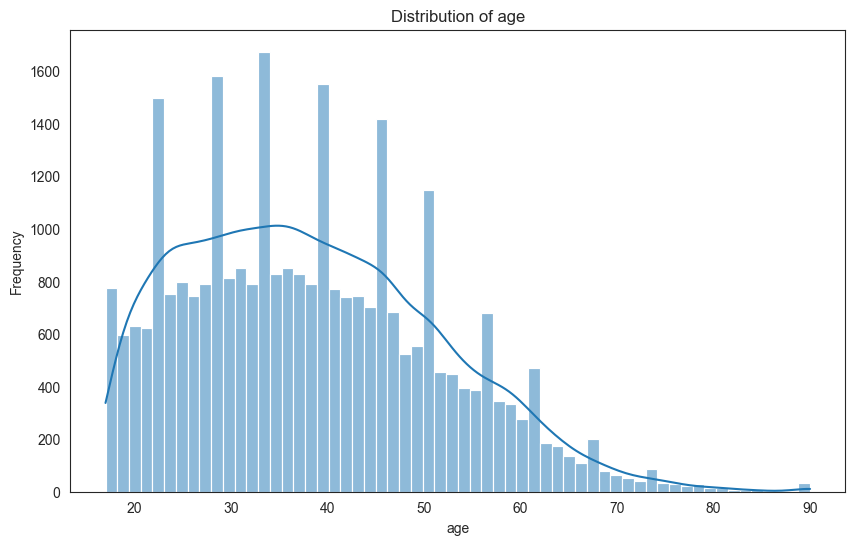

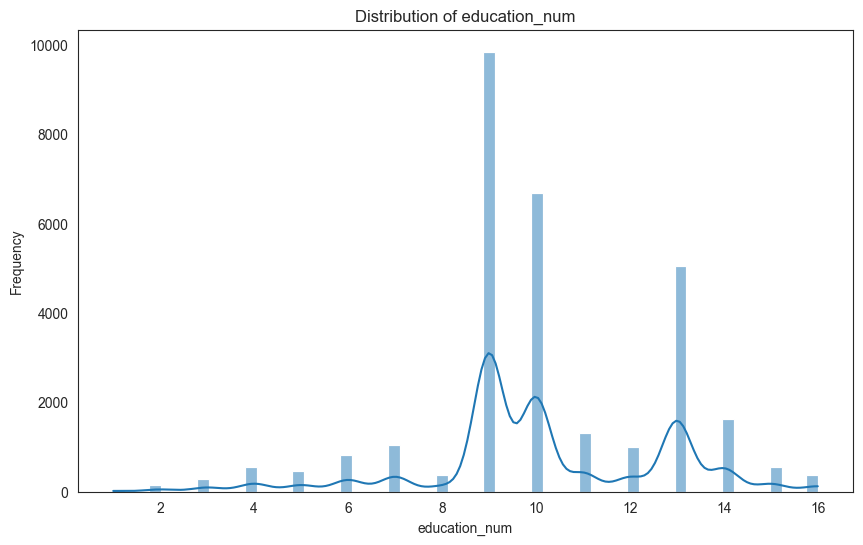

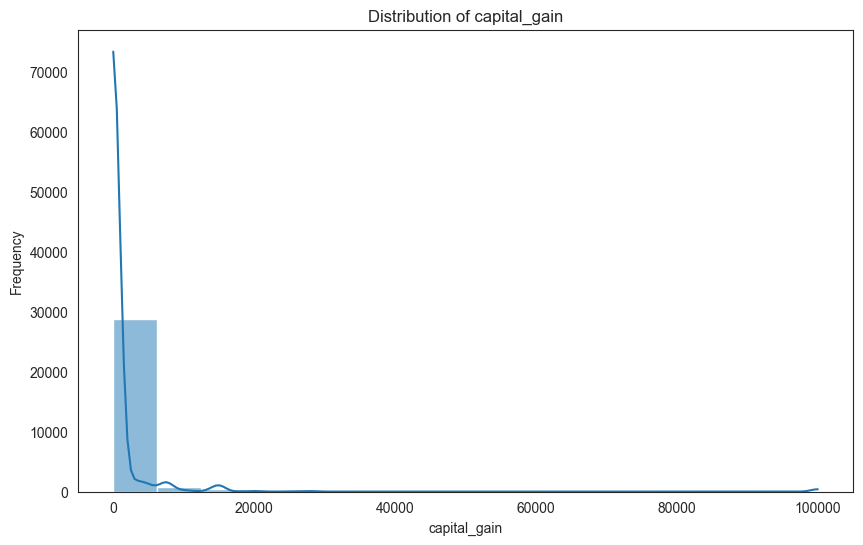

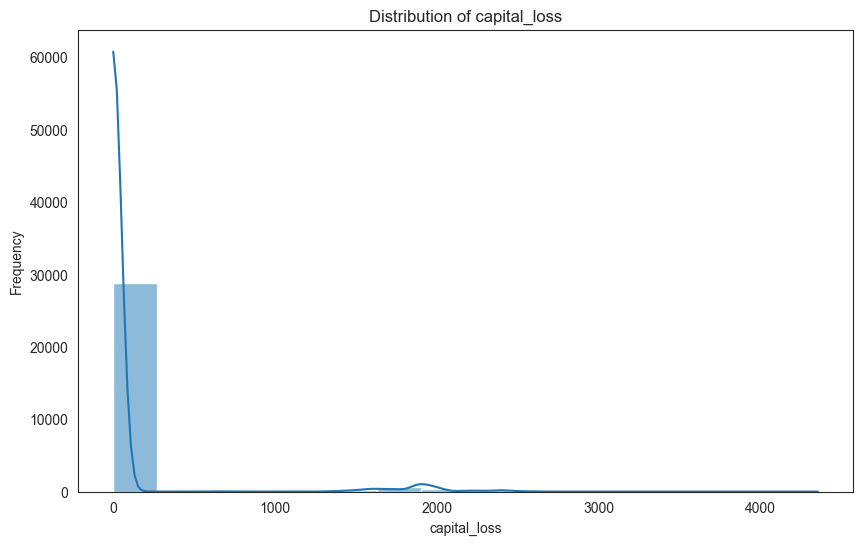

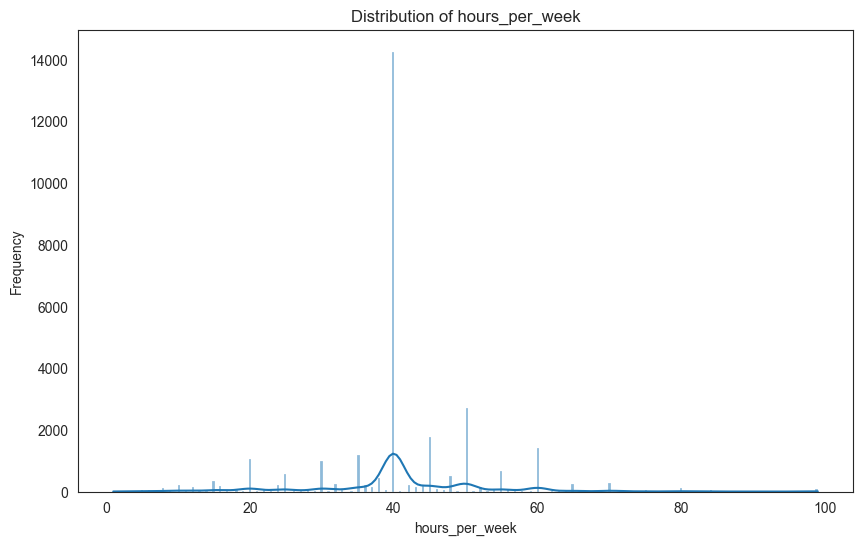

In [467]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
print(df[numerical_columns].describe())

# visualize the distribution of numerical columns
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

# determine feature types without hardcoding
feature_types = df.dtypes
numerical_columns = feature_types[feature_types != "object"].index
categorical_columns = feature_types[feature_types == "object"].index

## Analyze distributions of categorical columns

       workclass education      marital_status      occupation relationship  \
count      30162     30162               30162           30162        30162   
unique         7        16                   7              14            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       22286      9840               14065            4038        12463   

         race    sex native_country income  
count   30162  30162          30162  30162  
unique      5      2             41      2  
top     White   Male  United-States  <=50K  
freq    25933  20380          27504  22654  


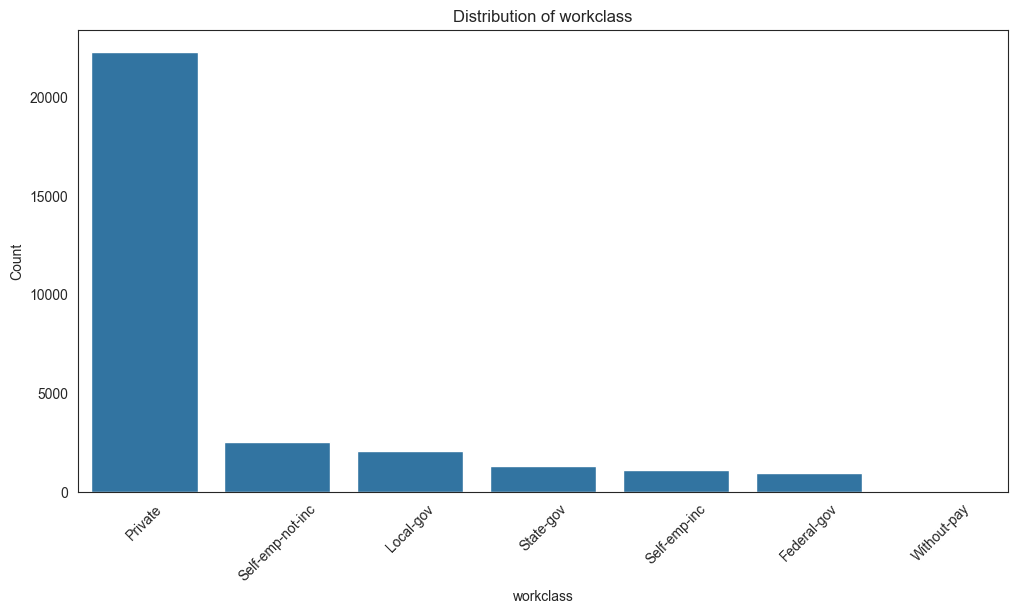

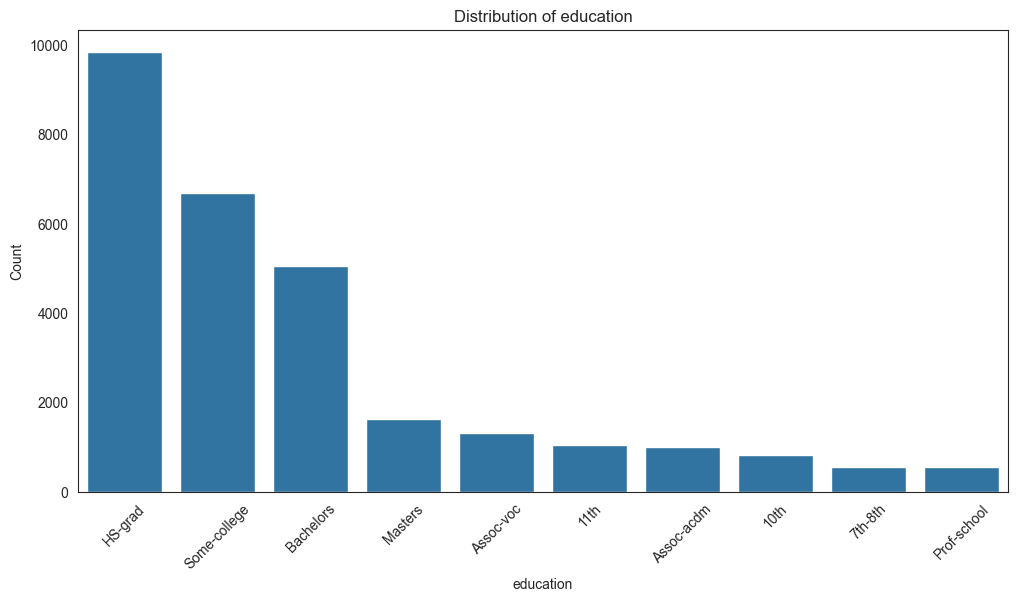

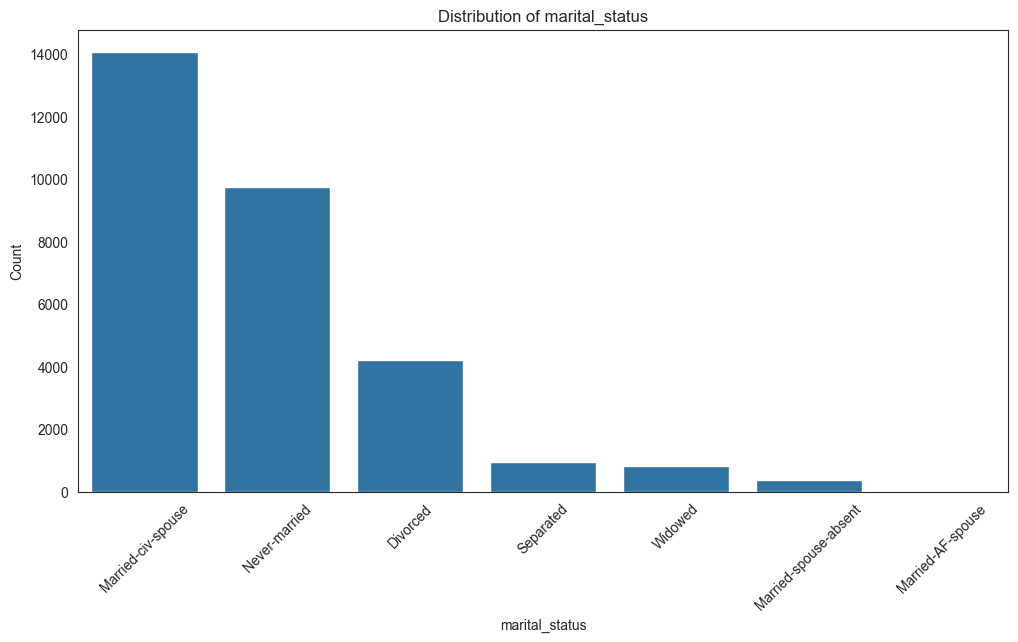

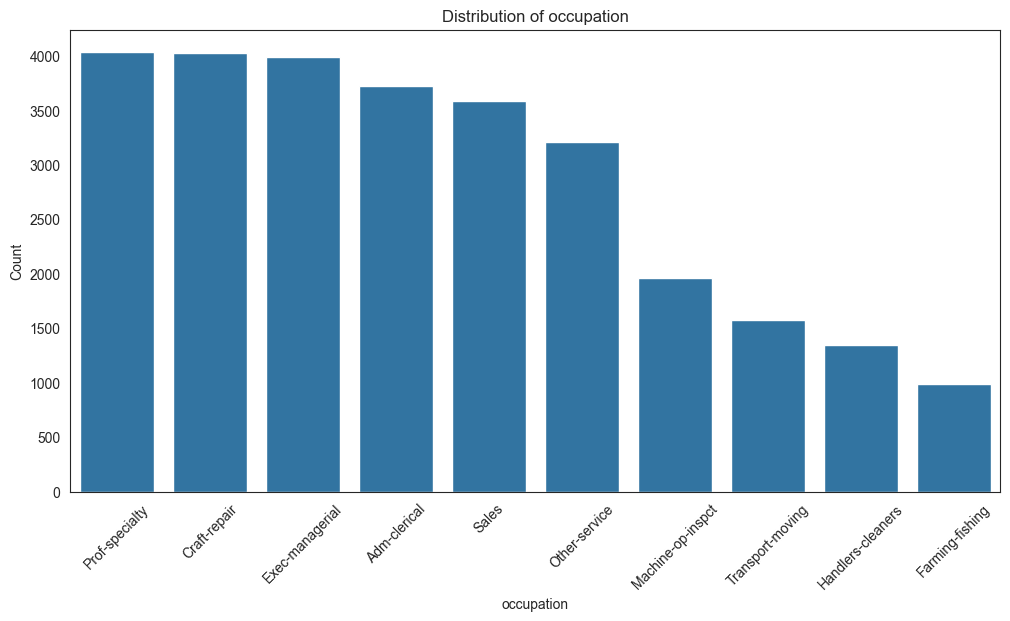

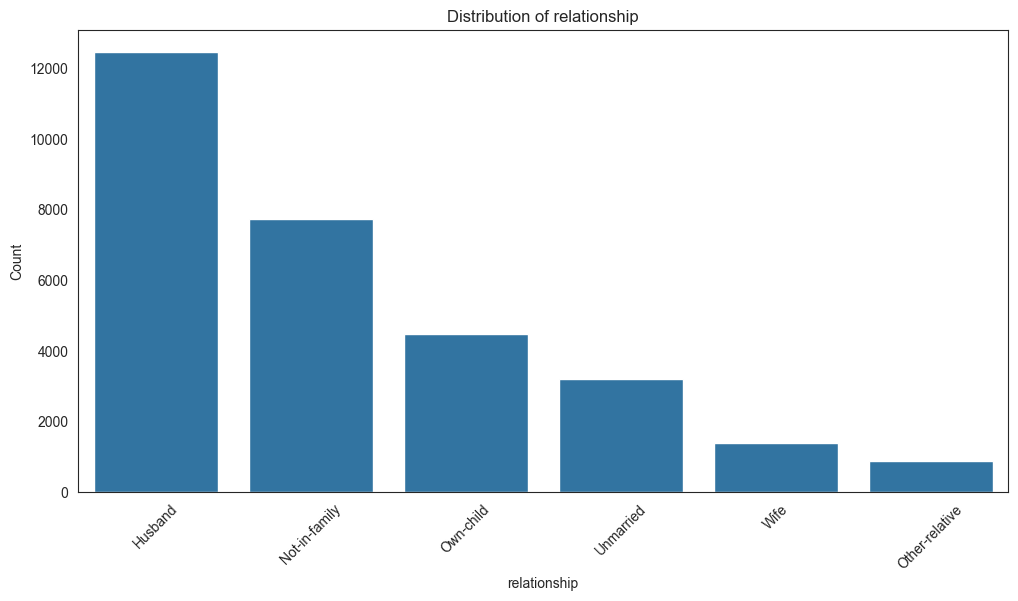

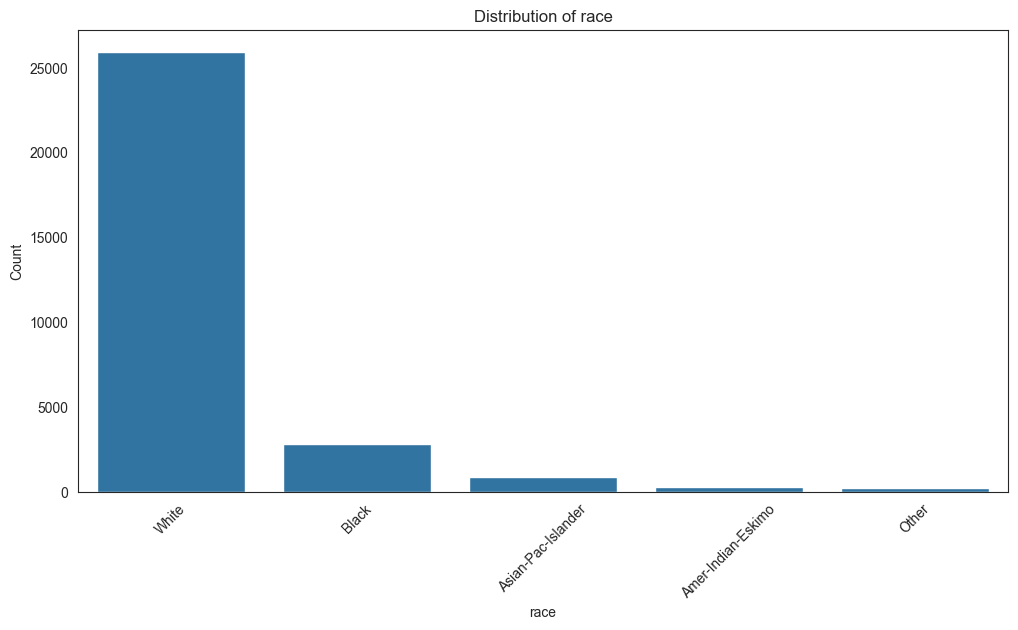

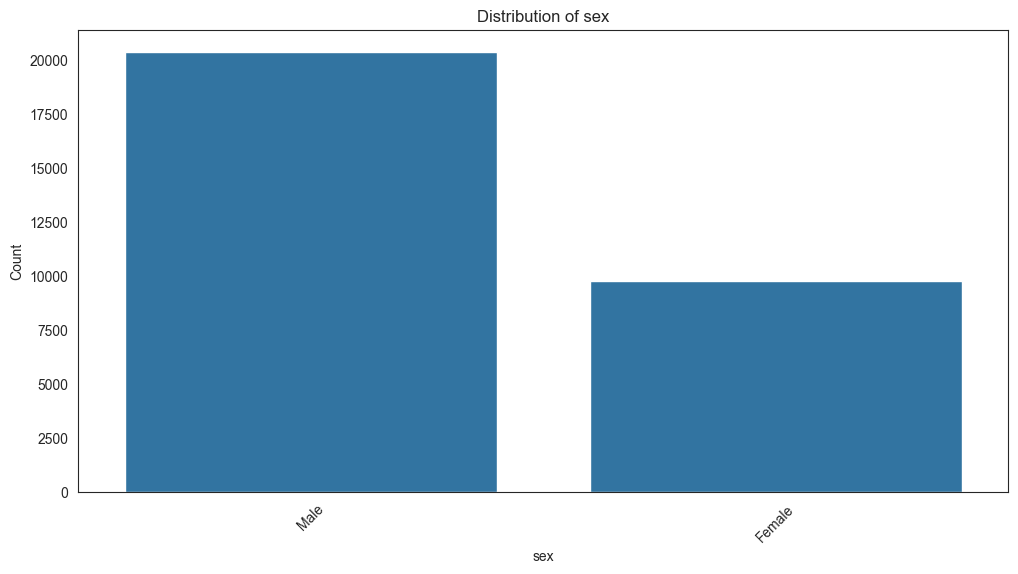

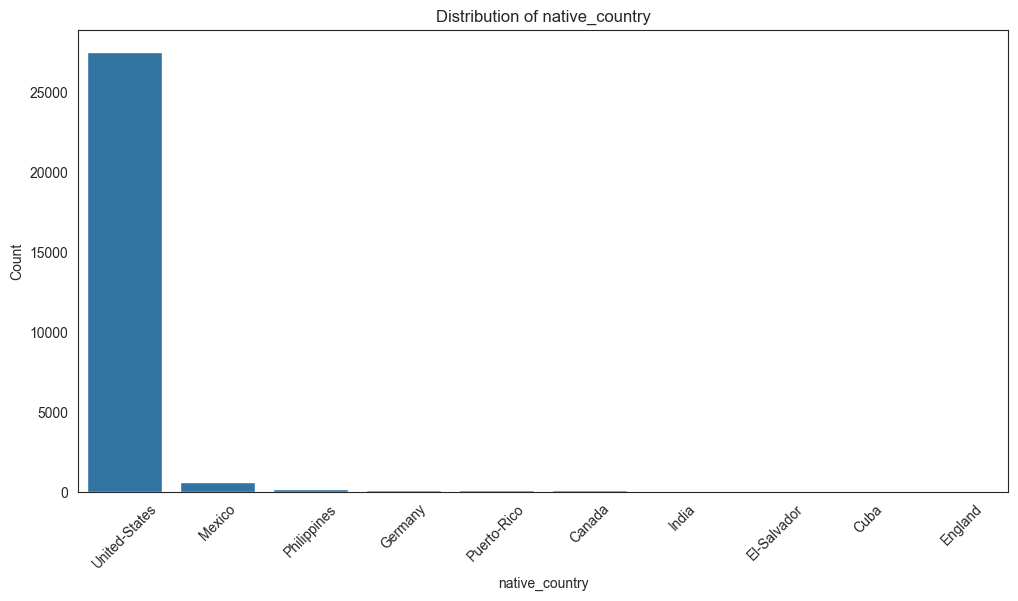

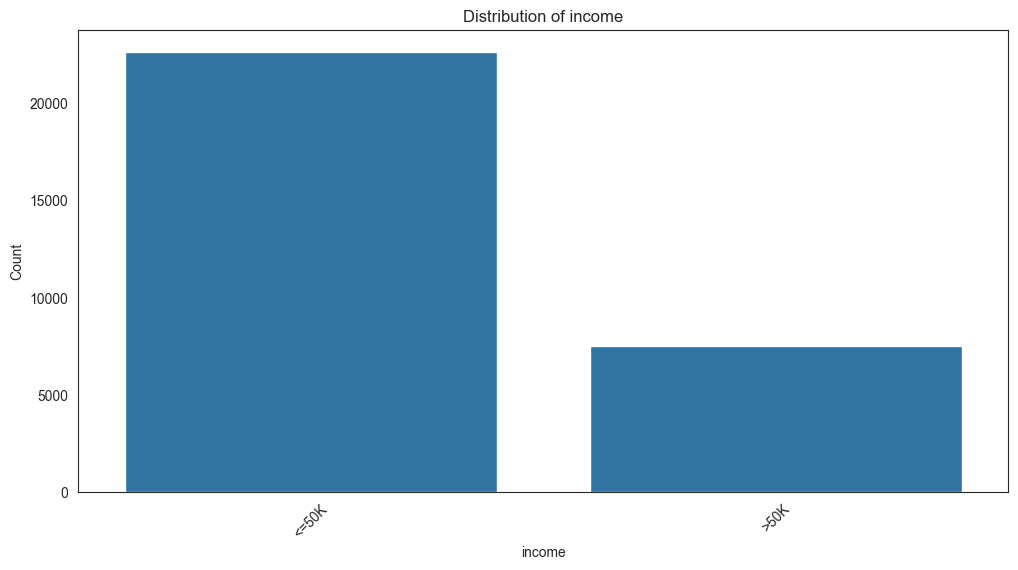

In [468]:
categorical_columns = df.select_dtypes(include=[object]).columns
print(df[categorical_columns].describe())

# visualize the distribution of categorical columns
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    top_10 = df[column].value_counts().head(10)
    sns.countplot(data=df, x=column, order=top_10.index)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

### **2. Problem Formulation & Model Selection (10 points)**
- Choose **two different modeling approaches** from the following categories:
  - **Statistical Algorithms** (e.g., **Expectation-Maximization (EM), Gaussian Mixture Models (GMM), Naive Bayes, Bayesian classifiers**).
  - **Optimization Algorithms** (e.g., **Linear Programming (LP), Integer Programming (IP), Dynamic Programming (DP), Quadratic Programming (QP), heuristic/metaheuristic methods**).
  - **Graph Algorithms** (e.g., **network construction based on occupation/education, shortest path analysis**).
  - **Supervised Learning** (classification or regression).
  - **Unsupervised Learning** (clustering, dimensionality reduction).
- **Formulate a problem statement** for each **chosen model type**, clearly defining:
  - **What you aim to achieve** using each approach.

## Problem Statements
###
- <strong>Supervised Learning</strong>: Which factors have the strongest influence on whether a person earns more than $50K per year?
- <strong>Unsupervised Learning</strong>: Can we identify distinct patterns in work habits and education levels that separate different income groups without directly using salary information?

### **3. Implementation (10 points)**
- Implement **both models** using Python and built-in functions from:
  - **Scikit-Learn**
  - **SciPy**
  - **NetworkX**
  - Or other relevant libraries.
- **Describe the methodology** behind each model and explain **why it is appropriate** for the problem you formulated.

## Supervised Learning Solution

Accuracy:  0.8430


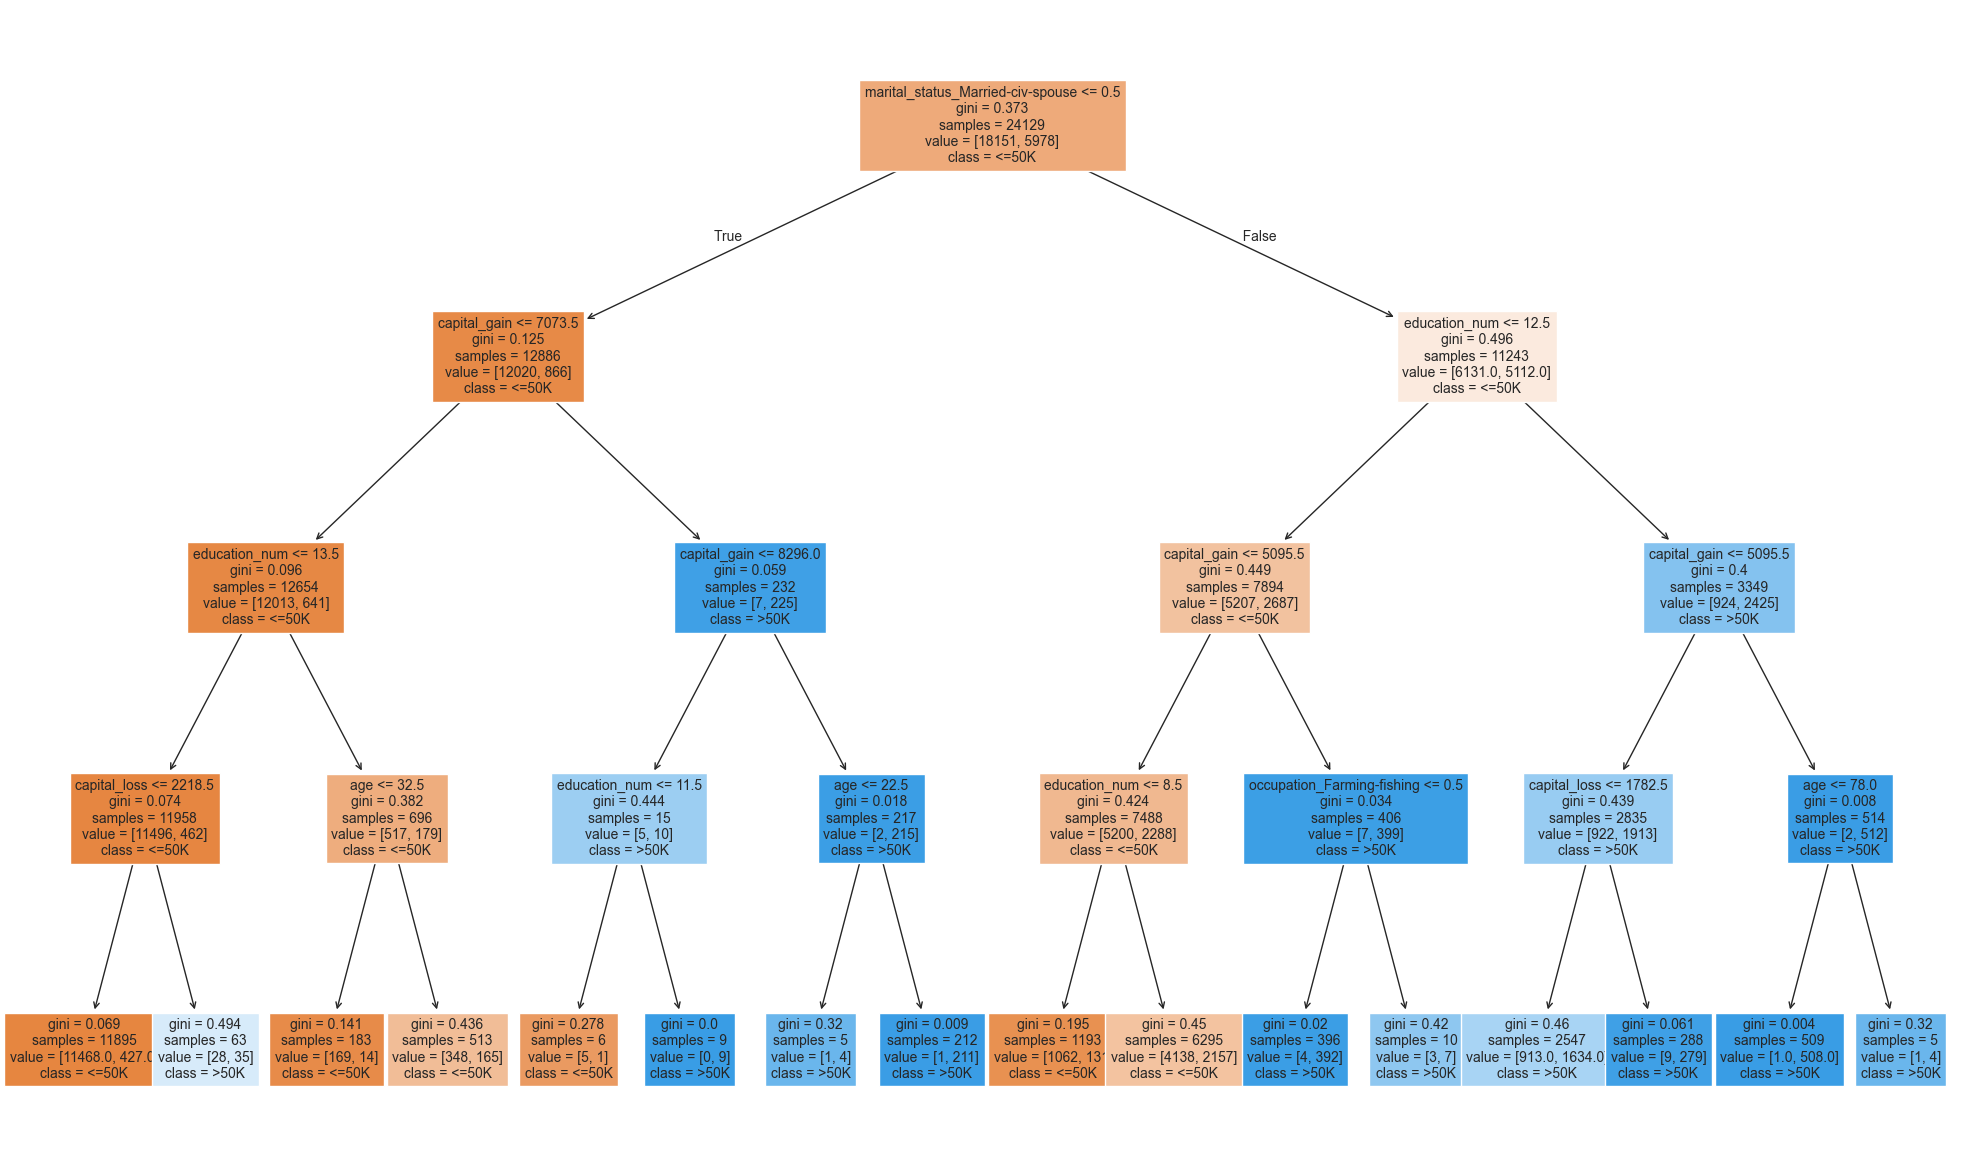

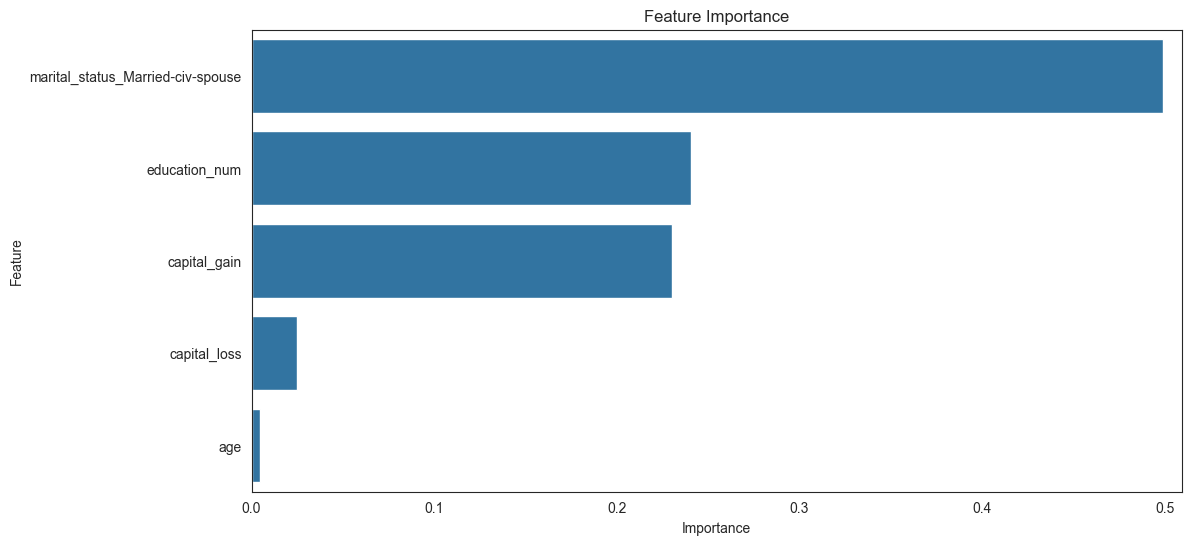

In [469]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

categorical_columns = df.select_dtypes(include=["object"]).columns.difference(["income"])
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# split the data into features and target
X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy: .4f}")

plt.figure(figsize=(25, 15))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=["<=50K", ">50K"], fontsize=10)
plt.show()

# feature importance
feature_importance = dt.feature_importances_
feature_importance_df = pd.DataFrame({"feature": X.columns, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

top_features = feature_importance_df.head(5)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x="importance", y="feature")
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.xlim(0, max(feature_importance_df["importance"]) + 0.01)  
plt.show()

### Methodology
#### Splits dataset into smaller groups based on the most important features, such as education level, hours worked per week, or capital gains. The tree structure makes it easy to see which variables contribute most to predicting income. There is also feature importance analysis to see which are the most influential factors. Decision trees are a good fit for this problem because they handle both numerical and categorical data, and clearly show relationships between features and outcomes. It was necessary to limit the depth of the tree and setting a minimum number of samples per split, because there were too many pieces in it. Minimizes it allowed us to capture high-level general trends.

## Unsupervised Learning Solution

Cluser Centers:
         age  education_num  capital_gain  capital_loss  hours_per_week  \
0  34.130496       9.856281    344.320945     51.663521       37.941395   
1  43.039498      10.404444   1890.760817    127.588631       44.125283   

   education_11th  education_12th  education_1st-4th  education_5th-6th  \
0        0.046601        0.017267           0.005135             0.0095   
1        0.022081        0.007406           0.004869             0.0096   

   education_7th-8th  ...  relationship_Own-child  relationship_Unmarried  \
0           0.014763  ...                0.281854                0.197189   
1           0.022423  ...                0.005143                0.009600   

   relationship_Wife  sex_Male  workclass_Local-gov  workclass_Private  \
0           0.000578  0.467745             0.064061           0.812247   
1           0.095796  0.897826             0.073305           0.660495   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  \

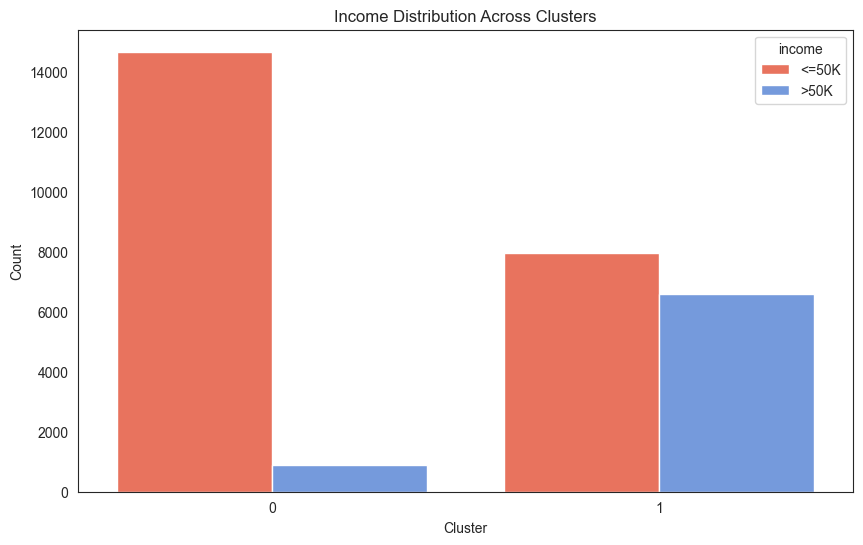

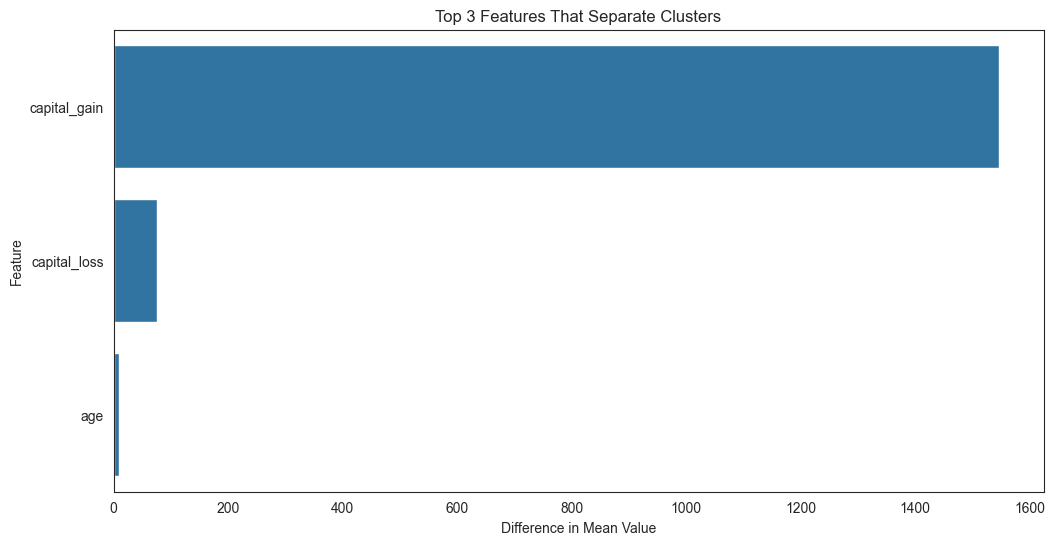

In [470]:
# use unsupervised learning to identify patterns without salary information
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_unsupervised = X

# standardize the data
scaler = StandardScaler()
X_unsupervised_scaled = scaler.fit_transform(X_unsupervised)

# fit KMeans clustering model
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_unsupervised_scaled)

# analyze feature differences between clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_center_df = pd.DataFrame(cluster_centers, columns=X_unsupervised.columns)
print("Cluser Centers:")
print(cluster_center_df)

# assign cluster labels
cluster_labels = kmeans.labels_
df["cluster"] = cluster_labels

# visualize the distribution of clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="cluster", hue="income", palette=["#FF6347", "#6495ED"])
plt.title("Income Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

feature_importance = np.abs(cluster_center_df.iloc[0] - cluster_center_df.iloc[1])
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values[:3], y=feature_importance.index[:3])
plt.title("Top 3 Features That Separate Clusters")
plt.xlabel("Difference in Mean Value")
plt.ylabel("Feature")
plt.show()


## Methodology
#### Finds hidden patterns in work habits and education levels without using salary information. Standardized the data and applied K-Means to form two different clusters. The factors that grouped individuals included education levels, work hours, and job types. These ended up aligning with what was expected of low or high-paying groups. This method is useful because it finds structure in the dataset, even though it was missing important information. It highlights the top three factors that separate the clusters, and that education and work-related factors strongly contribute to earnings potential. K-Means is an effective choice and is applicable when income data may be unavailable or unreliable.

### **4. Evaluation & Comparison (5 points)**
- **Compare the two approaches**:
  - **What insights does each model provide?**
  - **How do the results differ?**
  - **What are the trade-offs** between the two modeling techniques?

Supervised learning shows which factors have the biggest impact on income, laying out a clear relationship between the two to see which variables are the most important. Unsupervised learning groups people based on different factors without looking at income. Even though income isn’t taken into consideration when clustering, the groups end up being grouped based on income. This is because there is a correlation between certain attributes and being high earners. One cluster includes more people with higher education and work hours, which lines up with higher earnings, while the other includes people with lower education and fewer work hours.

Supervised learning is easier to understand since it gives direct explanations, but it requires labeled data, meaning income has to be known for each person. Unsupervised learning is less clear sometimes but comes in hand when trying to identify patterns without certain data.

# **Q3: Gaussian Mixture Models and Expectation-Maximization**

## **Analyzing runtime and implementing GMMs for a single-variate dataset (30 points total)**
The **Iris dataset** contains measurements of **sepal length, sepal width, petal length, and petal width** for three species of flowers: **Setosa, Versicolor, and Virginica**. In this assignment, you will focus on **one feature only** (e.g., **Petal Length**) and use **Gaussian Mixture Models (GMMs) with the Expectation-Maximization (EM) algorithm** to model the distribution of this feature.

Unlike traditional clustering, GMMs use **probabilistic modeling** to represent data as a **mixture of Gaussians**, making them useful for capturing **uncertainty** and **overlapping distributions**.

---

## **Tasks**

### **1. Understanding Gaussian Mixture Models and the EM Algorithm (5 points)**
- Explain how the **Expectation-Maximization (EM) algorithm** is used to fit a **Gaussian Mixture Model (GMM)**.
- Why is a **mixture of Gaussians** an appropriate way to model a **single feature's distribution**?
- Discuss how GMMs use **probabilities rather than hard assignments** to classify points.

- The EM calculates the probability that each data point belongs to each Gaussian component. It assigns a probability to each component. The probabilities are then used to updates the mean, variance, etc. This iterates until the parameter updates are slim to none.
- Many practical datasets contain multiple subpopulations within a single variable. A mixture of Gaussians combines multiple normal distributions to better represent the data’s structure.
- GMMs assign probabilities to each cluster, for example, 70% Cluster A and 30% Cluster B.

### **2. Implementation (15 points)**
- Load the **Iris dataset** and select **one numerical feature** (e.g., **Petal Length**).
- **Manually implement** the **Gaussian Mixture Model (GMM)** using the **Expectation-Maximization (EM) algorithm**:
  - **Do not** use `sklearn.mixture.GaussianMixture` or other built-in GMM solvers.
  - You may use **NumPy and Pandas** for matrix operations and calculations.
  - Initialize **random means, variances, and priors** for **three Gaussians** (since Iris has three species).
  - Implement the **E-step (Expectation)**: Compute the probability that each data point belongs to a given Gaussian.
  - Implement the **M-step (Maximization)**: Update the parameters of each Gaussian distribution.
  - Repeat until **convergence** (based on **log-likelihood stability**).

First 10 Soft Cluster Probabilities:
 [[7.96514512e-01 2.03450690e-01 3.47976032e-05]
 [7.96514512e-01 2.03450690e-01 3.47976032e-05]
 [8.09041893e-01 1.90936471e-01 2.16367521e-05]
 [7.82845573e-01 2.17098890e-01 5.55366494e-05]
 [7.96514512e-01 2.03450690e-01 3.47976032e-05]
 [7.51773718e-01 2.48088140e-01 1.38142291e-04]
 [7.96514512e-01 2.03450690e-01 3.47976032e-05]
 [7.82845573e-01 2.17098890e-01 5.55366494e-05]
 [7.96514512e-01 2.03450690e-01 3.47976032e-05]
 [7.82845573e-01 2.17098890e-01 5.55366494e-05]]


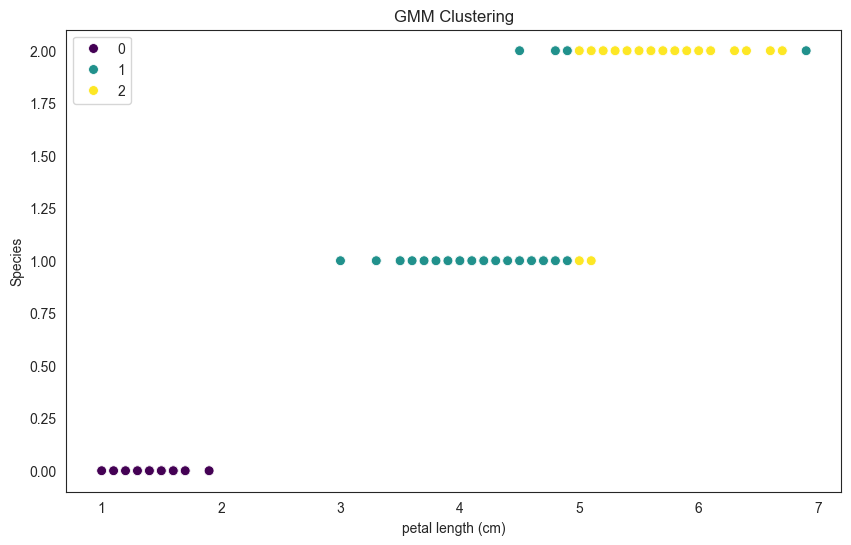

In [471]:
## Import the dataset ##
from sklearn.datasets import load_iris
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names) # O(1), theta(1), omega(1)
df['species'] = iris.target # O(1), theta(1), omega(1)

# select one feature for visualization
feature = 'petal length (cm)' # O(1), theta(1), omega(1)
df = df[['species', feature]] # O(1), theta(1), omega(1)

# standardize the data
scaler = StandardScaler() # O(1), theta(1), omega(1)
X_scaled = scaler.fit_transform(df[[feature]]) # O(n), theta(n), omega(n)

# manually implement GMM
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4): # O(1), theta(1), omega(1)
        self.n_components = n_components # O(1), theta(1), omega(1)
        self.max_iter = max_iter # O(1), theta(1), omega(1)
        self.tol = tol # O(1), theta(1), omega(1)

    def fit(self, X):
        # get the number of samples and features
        n_samples, n_features = X.shape # O(1), theta(1), omega(1)

        # initialize parameters
        self.pi = np.ones(self.n_components) / self.n_components # O(1), theta(1), omega(1)
        self.mu = np.linspace(X.min(), X.max(), self.n_components).reshape(-1, 1)  # O(1), theta(1), omega(1)
        self.sigma = np.array([np.var(X) * np.eye(n_features) for _ in range(self.n_components)])  # O(1), theta(1), omega(1)
        prev_log_likelihood = None # O(1), theta(1), omega(1)

        # EM algorithm
        for _ in range(self.max_iter):
            # E-step
            gamma = np.zeros((n_samples, self.n_components)) # O(1), theta(1), omega(1)
            # compute the probability of each data point belonging to each cluster
            for i in range(self.n_components): # O(n), theta(n), omega(n)
                gamma[:, i] = self.pi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i]) # O(n), theta(n), omega(n)
            # normalize gamma
            gamma /= np.maximum(gamma.sum(axis=1, keepdims=True), np.finfo(float).eps) # O(n), theta(n), omega(n)

            # Compute log-likelihood
            log_likelihood = np.sum(np.log(gamma.sum(axis=1))) # O(n), theta(n), omega(n)

            # check for convergence
            if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < self.tol: # O(1), theta(1), omega(1)
                break # O(1), theta(1), omega(1)

            # update the log likelihood
            prev_log_likelihood = log_likelihood # O(1), theta(1), omega(1)

            # M-step
            N = gamma.sum(axis=0) # O(n), theta(n), omega(n)
            # update the mixing coefficients
            self.pi = N / n_samples # O(1), theta(1), omega(1)
            # update the mean
            self.mu = (gamma.T @ X) / N[:, None] # O(n), theta(n), omega(n)
            # update the covariance matrix
            for i in range(self.n_components): # O(n^2), theta(n^2), omega(n^2)
                diff = X - self.mu[i] # O(n), theta(n), omega(n)
                # update the covariance matrix
                self.sigma[i] = (gamma[:, i, None] * diff).T @ diff / N[i] + np.eye(n_features) * 1e-6 # O(n^2), theta(n^2), omega(n^2)
  
    # predict the cluster for each data point
    def predict(self, X): # O(n), theta(n), omega(n)
        # get the number of samples
        n_samples = X.shape[0] # O(1), theta(1), omega(1)
        # compute the probability of each data point belonging to each cluster
        gamma = np.zeros((n_samples, self.n_components)) # O(1), theta(1), omega(1)
        # compute the probability of each data point belonging to each cluster
        for i in range(self.n_components): # O(n), theta(n), omega(n)
            gamma[:, i] = self.pi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i]) # O(n), theta(n), omega(n)
        # return the cluster with the highest probability
        return gamma.argmax(axis=1) # O(n), theta(n), omega(n)
    
    # predict the probability of each cluster for each data point
    def predict_proba(self, X): # O(n), theta(n), omega(n)
        # get the number of samples
        n_samples = X.shape[0] # O(1), theta(1), omega(1)
        # compute the probability of each data point belonging to each cluster
        gamma = np.zeros((n_samples, self.n_components)) # O(1), theta(1), omega(1)
        
        # compute the probability of each data point belonging to each cluster
        for i in range(self.n_components): # O(n), theta(n), omega(n)
            gamma[:, i] = self.pi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i]) # O(n), theta(n), omega(n)
        
        # normalize gamma
        gamma_sum = np.maximum(gamma.sum(axis=1, keepdims=True), np.finfo(float).eps) # O(n), theta(n), omega(n)
        return gamma / gamma_sum # O(n), theta(n), omega(n)

    
# fit GMM model
gmm = GMM(n_components=3) # O(1), theta(1), omega(1)
gmm.fit(X_scaled) # O(n), theta(n), omega(n)

# predict clusters
cluster = gmm.predict(X_scaled) # O(n), theta(n), omega(n)

# print probabilities to check if soft assignments are reasonable
probs = gmm.predict_proba(X_scaled) # O(n), theta(n), omega(n)

print("First 10 Soft Cluster Probabilities:\n", probs[:10]) # O(1), theta(1), omega(1)

# visualize the clusters
plt.figure(figsize=(10, 6)) # O(1), theta(1), omega(1)
sns.scatterplot(x=df[feature], y=df['species'], hue=cluster, palette='viridis', s=50) # O(n), theta(n), omega(n)
plt.ylabel("Species") # O(1), theta(1), omega(1)
plt.title("GMM Clustering") # O(1), theta(1), omega(1)
plt.xlabel(feature) # O(1), theta(1), omega(1)
plt.show()  # O(1), theta(1), omega(1)


### **3. Runtime Complexity Analysis (5 points)**
- Perform a **line-by-line runtime analysis** of your implementation.
- Determine the **overall time complexity** in **Big O, Big Theta, and Big Omega notation**.
- Discuss the factors affecting runtime, such as:
  - The number of **iterations until convergence**.
  - The number of **data points**.
  - The complexity of **computing probabilities and updating parameters**.

Runtime depends on how many times it iterates, how much data there is, how many clusters it's trying to find, and how many features each data point has. The slowest parts are calculating probabilities and updating the covariance matrices. Using methods like PCA to lower dimensions, diagonal covariance matrices to simplify calculations, or better initialization techniques like k-means++ can help make the process faster. If there’s too much data, using mini-batches or random sampling can speed things up without losing much accuracy.

### **4. Visualization (5 points)**
- **Plot the raw feature values** (e.g., **petal length**) as a **histogram**.
- **Overlay the fitted Gaussian distributions** on the same plot.
  - Scale the Gaussian curves so they **align properly** with the histogram.
  - Ensure the plot **visually distinguishes between the three Gaussians**.

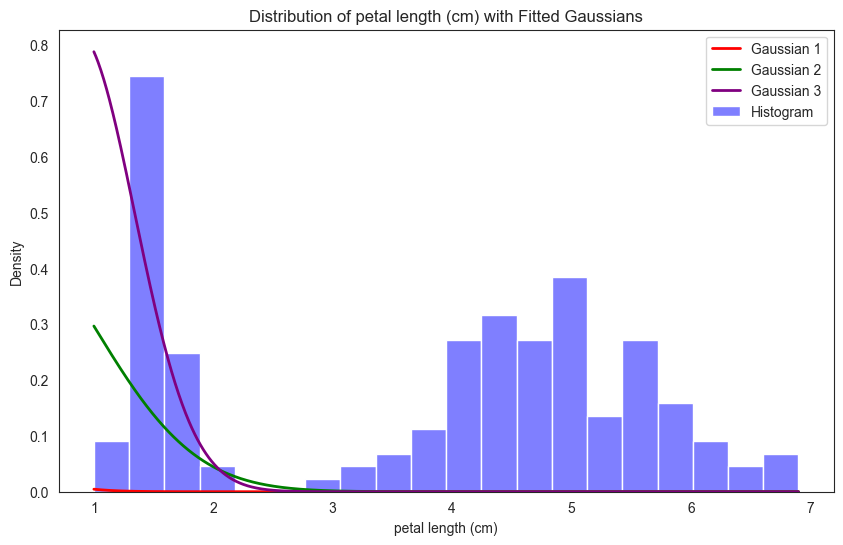

In [472]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# create the figure
plt.figure(figsize=(10, 6))

# plot histogram of feature values
sns.histplot(df[feature], kde=False, bins=20, stat="density", color='blue', alpha=0.5, label="Histogram")

# overlay GMM components
x_values = np.linspace(df[feature].min(), df[feature].max(), 1000)
colors = ['red', 'green', 'purple']

for i, (mu, sigma) in enumerate(zip(gmm.mu.flatten(), np.sqrt(gmm.sigma.flatten()))):
    y_values = norm.pdf(x_values, mu, sigma)  # Use normal PDF
    plt.plot(x_values, y_values, color=colors[i], lw=2, label=f'Gaussian {i + 1}')

plt.title(f"Distribution of {feature} with Fitted Gaussians")
plt.xlabel(feature)
plt.ylabel("Density")
plt.legend()
plt.show()